In [1]:
import sys
import os
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from IPython.display import display, HTML
from collections import defaultdict
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
from datasets.Waymo import WaymoDataset, waymo_collate_fn
from model import OccupancyFlowNetwork
from visualize import render_observed_scene_state, render_flow_at_spacetime, render_flow_field, render_occupancy_and_flow_unoccluded

In [26]:
NUM_SCENES = 16#25
MAX_SCENES_TO_RENDER = 1

tfrecord_path = '../../data1/waymo_dataset/v1.1/waymo_open_dataset_motion_v_1_1_0/uncompressed/tf_example/validation'
idx_path = '../../data1/waymo_dataset/v1.1/idx/validation'
dataset = WaymoDataset(tfrecord_path, idx_path)
dataloader = DataLoader(dataset, batch_size=NUM_SCENES, collate_fn=waymo_collate_fn)

scenes = []
#for _ in range(NUM_SCENES):
scenes.append(next(iter(dataloader)))

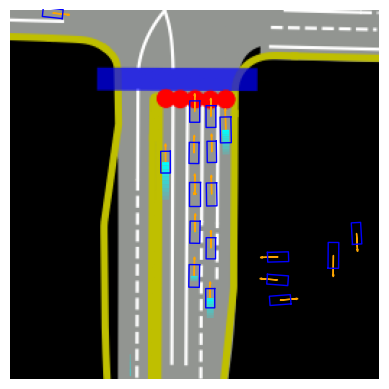

In [27]:
count = 0
for road_map, agent_trajectories, _, _, _, _, _, _ in scenes:
    count += 1
    if count > MAX_SCENES_TO_RENDER:
        break
    
    render_observed_scene_state(road_map[0], agent_trajectories[0])#, f'examples/observed_scene_state/sample{count}.png')

In [28]:
count = 0
for road_map, _, _, flow_field_positions, flow_field_times, flow_field_velocities, _, _ in scenes:
    count += 1
    if count > MAX_SCENES_TO_RENDER:
        break
    
    anim = render_flow_at_spacetime(road_map[0], flow_field_times[0], flow_field_positions[0], flow_field_velocities[0])#, f'examples/ground_truth/sample{count}.gif')
    display(HTML(anim.to_jshtml()))

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [31]:
def occupancy_alignment(flow_field, scene_context,
                        agent_ids, positions, times):
    occupancy_loss = 0
    count = 0

    agent_groups = defaultdict(list)
    [agent_groups[round(val.item(), 1)].append(idx) for idx, val in enumerate(agent_ids)]

    for id, agent_indices in agent_groups.items():#agent_groups.values():
        agent_poistions = positions[agent_indices]
        agent_times = times[agent_indices]
        
        time_groups = defaultdict(list)
        [time_groups[round(val.item(), 1)].append(idx) for idx, val in enumerate(agent_times)]

        occupancy = []
        integration_times = []

        for time, time_indices in time_groups.items():
            integration_times.append(time)
            occupancy.append(agent_poistions[time_indices])

        initial_value = occupancy[0].unsqueeze(0) # TODO: unsqueeze is weird here we only do it because of ode expected shape...
        integration_times = torch.FloatTensor(integration_times).to(times.device)
        estimated_occupancy = flow_field.warp_occupancy(initial_value, integration_times, scene_context, use_custom=True)

        for i in range(len(occupancy)):
            occupancy_loss += torch.mean(torch.abs(estimated_occupancy[i].squeeze(0) - occupancy[i]))
            count += 1
            
    return occupancy_loss / count

In [ ]:
flow_field = OccupancyFlowNetwork(road_map_image_size=256, road_map_window_size=8, 
                                  trajectory_feature_dim=10, 
                                  embedding_dim=256, 
                                  flow_field_hidden_dim=256, flow_field_fourier_features=0).to(device)
flow_field.train()


optim = torch.optim.Adam(flow_field.parameters(), lr=1e-4, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.999)

EPOCHS = 3000
for epoch in range(EPOCHS):
    epoch_loss = 0
    for road_map, agent_trajectories, flow_field_agent_ids, flow_field_positions, flow_field_times, flow_field_velocities, agent_mask, flow_field_mask in scenes:
        road_map = road_map.to(device)
        agent_trajectories = agent_trajectories.to(device)
        p = flow_field_positions.to(device)
        t = flow_field_times.to(device)
        v = flow_field_velocities.to(device)
        agent_mask = agent_mask.to(device)
        flow_field_mask = flow_field_mask.to(device)
    
        scene_context = flow_field.scene_encoder(road_map, agent_trajectories)
        flow = flow_field.flow_field(t, p, scene_context)
        #flow = flow_field(t, p, road_map, agent_trajectories, agent_mask)
        flow_field_mask = flow_field_mask.view(-1)
        flow = flow.view(-1, 2)[flow_field_mask == 1]
        v = v.view(-1, 2)[flow_field_mask == 1]

        flow_loss = F.mse_loss(flow, v)
        loss = flow_loss

        optim.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(flow_field.parameters(), max_norm=1.0)
        optim.step()

        epoch_loss += loss

    scheduler.step()

    #epoch_loss /= NUM_SCENES
    
    if epoch == 0 or (epoch + 1) % 100 == 0:
        print(f'epoch {epoch+1} loss: {epoch_loss.item()}')

epoch 1 loss: 20.723514556884766
epoch 100 loss: 10.498946189880371
epoch 200 loss: 7.949115753173828
epoch 300 loss: 7.040297031402588
epoch 400 loss: 5.9736480712890625
epoch 500 loss: 4.926357269287109
epoch 600 loss: 4.264944076538086
epoch 700 loss: 3.9519221782684326
epoch 800 loss: 3.672480821609497
epoch 900 loss: 2.9145073890686035
epoch 1000 loss: 2.3895175457000732
epoch 1100 loss: 2.0875399112701416
epoch 1200 loss: 1.9188499450683594
epoch 1300 loss: 1.8242567777633667
epoch 1400 loss: 1.7398953437805176


KeyboardInterrupt: 

In [ ]:
count = 0
for road_map, agent_trajectories, _, positions, times, _, _, _ in scenes:
    count += 1
    if count > MAX_SCENES_TO_RENDER:
        break

    road_map = road_map.to(device)
    agent_trajectories = agent_trajectories.to(device)
    positions = positions.to(device)
    times = times.to(device)
    
    scene_context = flow_field.scene_encoder(road_map, agent_trajectories)
    anim = render_occupancy_and_flow_unoccluded(flow_field, road_map, times, positions, 11, scene_context, f'examples/unaligned_occupancy_estimate/sample{count}.gif')
    #display(HTML(anim.to_jshtml()))

In [ ]:
# TODO: I wonder if this should be part of the waymo collate function
def construct_agent_trajectories(agent_ids, positions, times):
    #print(agent_ids.shape)
    #print(positions.shape)
    #print(times.shape)
    time_groups = defaultdict(list)
    [time_groups[round(val.item(), 1)].append(idx) for idx, val in enumerate(times)]
    integration_times = torch.FloatTensor(sorted([t for t in time_groups.keys() if t <= 9.0])).to(times.device)

    #trajectories = [{} for _ in range(len(time_groups.keys()))]
    trajectories = [{} for _ in range(91)]
    #present = [defaultdict(lambda: False) for _ in range(len(time_groups.keys()))]
    present = [defaultdict(lambda: False) for _ in range(91)]
    #initial_values = [[] for _ in range(len(time_groups.keys()))]
    initial_values = [[] for _ in range(91)]
    agent_seen = set()
    agent_offsets = {}
    offset = 0

    #print(time_groups.keys())
    for time in sorted(time_groups.keys()):
        time_indicies = time_groups[time]
        agent_ids_at_time = agent_ids[time_indicies]
        time_index = int(time * 10)

        agent_groups = defaultdict(list)
        #[agent_groups[int(val.item())].append(idx) for idx, val in enumerate(agent_ids_at_time)]
        for local_idx, val in enumerate(agent_ids_at_time):
            global_idx = time_indicies[local_idx]
            agent_groups[int(val.item())].append(global_idx)

        for id, agent_indicies in agent_groups.items():
            agent_positions_at_time = positions[agent_indicies]

            #print(f'{time_index}-{len(trajectories)}')
            if time_index < len(trajectories): # only train up to the forecast horizon
                trajectories[time_index][id] = agent_positions_at_time
                present[time_index][id] = True
            
                if id not in agent_seen:
                    agent_seen.add(id)
                    initial_values[time_index].append(agent_positions_at_time)
                    num_agent_positions = agent_positions_at_time.shape[0]
                    start = offset
                    end = offset + num_agent_positions
                    agent_offsets[id] = (start, end)
                    offset = end

    return trajectories, present, initial_values, agent_offsets, integration_times, list(agent_seen)

def construct_agent_trajectories2(agent_ids, positions, times):
    rounded_times = torch.round(times * 10) / 10.0
    unique_times = torch.unique(rounded_times)
    integration_times = unique_times[unique_times <= 9.0]

    num_bins = 91
    trajectories = [{} for _ in range(num_bins)]
    present = [defaultdict(lambda: False) for _ in range(num_bins)]
    initial_values = [[] for _ in range(num_bins)]

    agent_seen = set()
    agent_offsets = {}
    offset = 0

    for time_val in integration_times:
        mask = rounded_times == time_val
        time_indices = torch.nonzero(mask.flatten(), as_tuple=False).squeeze(1)
        agent_ids_at_time = agent_ids[time_indices]
        time_index = int((time_val * 10).item())

        unique_ids = torch.unique(agent_ids_at_time)
        for agent_id in unique_ids.tolist():
            agent_mask = agent_ids_at_time == agent_id
            agent_indices = torch.nonzero(agent_mask.flatten(), as_tuple=False).squeeze(1)
            global_indices = time_indices[agent_indices]
            agent_positions = positions[global_indices]

            trajectories[time_index][agent_id] = agent_positions
            present[time_index][agent_id] = True

            if agent_id not in agent_seen:
                agent_seen.add(agent_id)
                initial_values[time_index].append(agent_positions)
                num_agent_positions = agent_positions.shape[0]
                start = offset
                end = offset + num_agent_positions
                agent_offsets[agent_id] = (start, end)
                offset = end

    return trajectories, present, initial_values, agent_offsets, integration_times, list(agent_seen)

def reconstruct_trajectories(estimated_occupancy, present, agent_offsets, integration_times, agent_ids):
    #reconstructed_trajectories = [{} for _ in range(integration_times.shape[0])]
    reconstructed_trajectories = [{} for _ in range(91)]
    for time_index, _ in enumerate(integration_times):
        for id in agent_ids:
            if present[time_index][id]:
                start, end = agent_offsets[id]
                estimated_occupancy_at_time = estimated_occupancy[time_index][0]
                reconstructed_trajectories[time_index][id] = estimated_occupancy_at_time[start:end]
    return reconstructed_trajectories

def occupancy_alignment2(flow_field, scene_context,
                         #agent_ids, positions, times):
                         trajectories, present, initial_values, agent_offsets, integration_times, ids):
    #trajectories, present, initial_values, agent_offsets, integration_times, ids = construct_agent_trajectories(agent_ids, positions, times)
    estimated_occupancy = flow_field.warp_occupancy(initial_values, integration_times, scene_context)
    estimated_trajectories = reconstruct_trajectories(estimated_occupancy, present, agent_offsets, integration_times, ids)
    
    occupancy_loss = 0
    count = 0

    for time_index, _ in enumerate(integration_times):
        for id in ids:
            if present[time_index][id]:
                ground_truth_positions = trajectories[time_index][id]
                estimated_positions = estimated_trajectories[time_index][id]
                occupancy_loss += torch.mean(torch.abs(ground_truth_positions - estimated_positions))
                count += 1
                
    return occupancy_loss / count

def occupancy_alignment3(flow_field, scene_context,
                         agent_ids, positions, times):
    trajectories, present, initial_values, agent_offsets, integration_times, ids = construct_agent_trajectories2(agent_ids, positions, times)
    estimated_occupancy = flow_field.warp_occupancy(initial_values, integration_times, scene_context)
    estimated_trajectories = reconstruct_trajectories(estimated_occupancy, present, agent_offsets, integration_times, ids)
    
    occupancy_loss = 0
    count = 0

    for time_index, _ in enumerate(integration_times):
        for id in ids:
            if present[time_index][id]:
                ground_truth_positions = trajectories[time_index][id]
                estimated_positions = estimated_trajectories[time_index][id]
                occupancy_loss += torch.mean(torch.abs(ground_truth_positions - estimated_positions))
                count += 1
                
    return occupancy_loss / count

for param in flow_field.scene_encoder.parameters():
    param.requires_grad = False

optim = torch.optim.Adam(flow_field.flow_field.parameters(), lr=1e-5, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.999)

# occupancy_alignment_tensors = []
# with torch.no_grad():
#     for road_map, agent_trajectories, flow_field_agent_ids, flow_field_positions, flow_field_times, flow_field_velocities, _, _ in scenes:
#         road_map = road_map.to(device)
#         agent_trajectories = agent_trajectories.to(device)
#         p = flow_field_positions.to(device)
#         t = flow_field_times.to(device)
#         v = flow_field_velocities.to(device)
    
#         scene_context = flow_field.scene_encoder(road_map, agent_trajectories)
#         trajectories, present, initial_values, agent_offsets, integration_times, ids = construct_agent_trajectories(flow_field_agent_ids[0], p[0], t[0])
#         occupancy_alignment_tensors.append((trajectories, present, initial_values, agent_offsets, integration_times, ids, scene_context))

EPOCHS = 1000
for epoch in range(EPOCHS):
    epoch_flow_loss = 0
    epoch_occupancy_loss = 0
    epoch_loss = 0
    #for road_map, agent_trajectories, flow_field_agent_ids, flow_field_positions, flow_field_times, flow_field_velocities, _, _ in scenes:
    for i in range(len(scenes)):
        road_map, agent_trajectories, flow_field_agent_ids, flow_field_positions, flow_field_times, flow_field_velocities, _, _ = scenes[i]
        #trajectories, present, initial_values, agent_offsets, integration_times, ids, scene_context = occupancy_alignment_tensors[i]

        road_map = road_map.to(device)
        agent_trajectories = agent_trajectories.to(device)
        flow_field_agent_ids = flow_field_agent_ids.to(device)
        p = flow_field_positions.to(device)
        t = flow_field_times.to(device)
        v = flow_field_velocities.to(device)
    
        with torch.no_grad():
            scene_context = flow_field.scene_encoder(road_map, agent_trajectories)
        flow = flow_field.flow_field(t, p, scene_context)

        flow_loss = F.mse_loss(flow, v)

        #occupancy_loss = occupancy_alignment2(flow_field, scene_context,
        #                                      trajectories, present, initial_values, agent_offsets, integration_times, ids)
        occupancy_loss = occupancy_alignment3(flow_field, scene_context, flow_field_agent_ids[0], p[0], t[0])

        #print(f'ol2: {occupancy_loss}')
        #print(f'ol3: {ol3}')

        loss = flow_loss + occupancy_loss

        optim.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(flow_field.parameters(), max_norm=1.0)
        optim.step()

        epoch_flow_loss += flow_loss
        epoch_occupancy_loss += occupancy_loss
        epoch_loss += loss

    scheduler.step()

    epoch_flow_loss /= NUM_SCENES
    epoch_occupancy_loss /= NUM_SCENES
    epoch_loss /= NUM_SCENES
    
    #if epoch == 0 or (epoch + 1) % 100 == 0:
    print(f'epoch {epoch+1} flow_loss: {epoch_flow_loss.item()}')
    print(f'epoch {epoch+1} occupancy_loss: {epoch_occupancy_loss.item()}')
    print(f'epoch {epoch+1} loss: {epoch_loss.item()}')

In [ ]:
count = 0
for road_map, agent_trajectories, _, flow_field_positions, flow_field_times, _, _, _ in scenes:
    count += 1
    if count > MAX_SCENES_TO_RENDER:
        break

    road_map = road_map.to(device)
    agent_trajectories = agent_trajectories.to(device)
    p = flow_field_positions.to(device)
    t = flow_field_times.to(device)
    flow = flow_field(t, p, road_map, agent_trajectories)

    anim = render_flow_at_spacetime(road_map[0].cpu(), flow_field_times[0].cpu(), flow_field_positions[0].cpu(), flow[0].detach().cpu())
    display(HTML(anim.to_jshtml()))

In [ ]:
count = 0
for road_map, agent_trajectories, _, _, _, _, _, _ in scenes:
    count += 1
    if count > MAX_SCENES_TO_RENDER:
        break

    road_map = road_map.to(device)
    agent_trajectories = agent_trajectories.to(device)
    
    scene_context = flow_field.scene_encoder(road_map, agent_trajectories)
    anim = render_flow_field(flow_field, road_map, road_map[0].shape[0], 10, 91, 10, scene_context)
    display(HTML(anim.to_jshtml()))

In [ ]:
count = 0
for road_map, agent_trajectories, _, positions, times, _, _, _ in scenes:
    count += 1
    if count > MAX_SCENES_TO_RENDER:
        break

    road_map = road_map.to(device)
    agent_trajectories = agent_trajectories.to(device)
    positions = positions.to(device)
    times = times.to(device)
    
    scene_context = flow_field.scene_encoder(road_map, agent_trajectories)
    anim = render_occupancy_and_flow_unoccluded(flow_field, road_map, times, positions, 11, scene_context, f'examples/aligned_occupancy_estimate/sample{count}.gif')
    #display(HTML(anim.to_jshtml()))